C:\Users\ilaki\AppData\Local\Temp\ipykernel_6748\1235866255.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


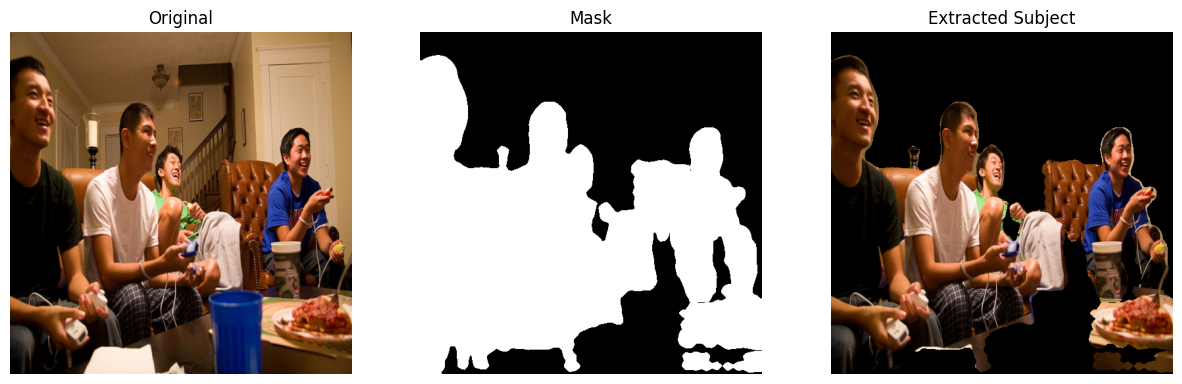

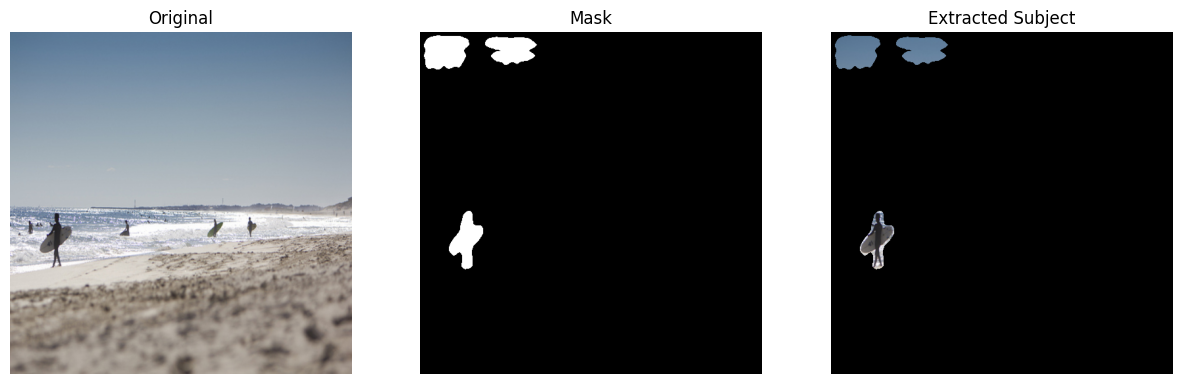

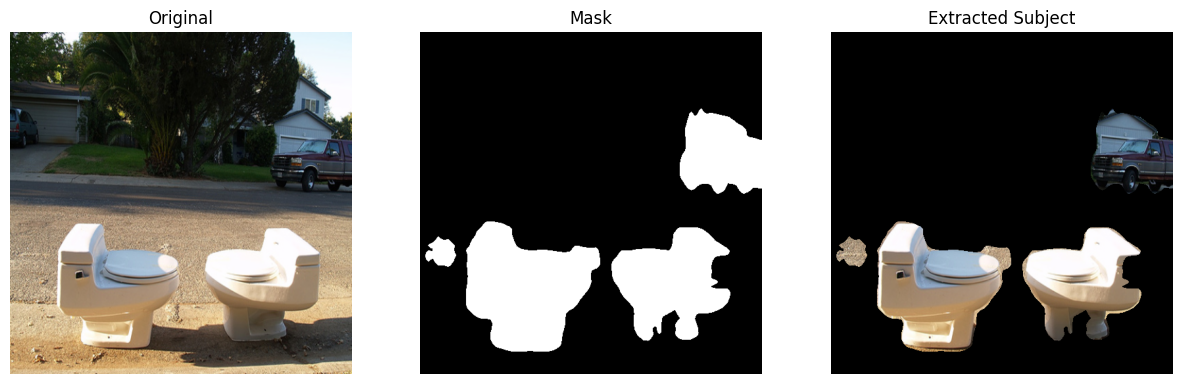

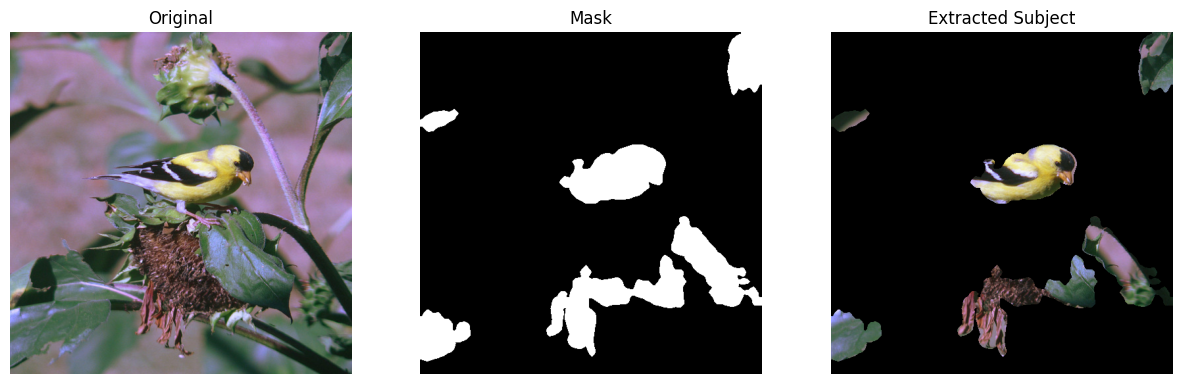

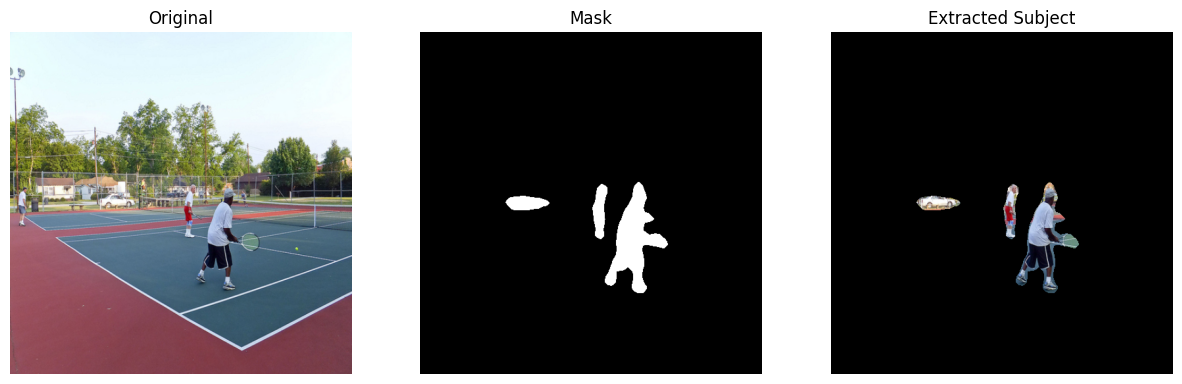

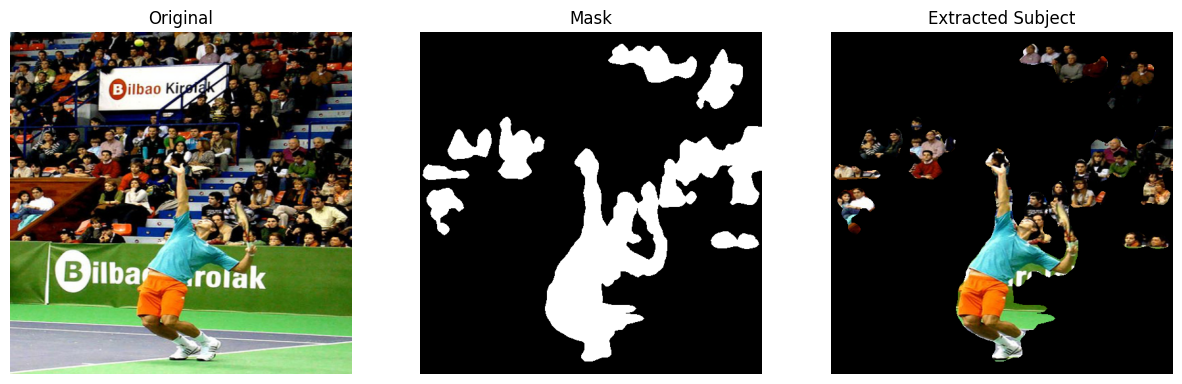

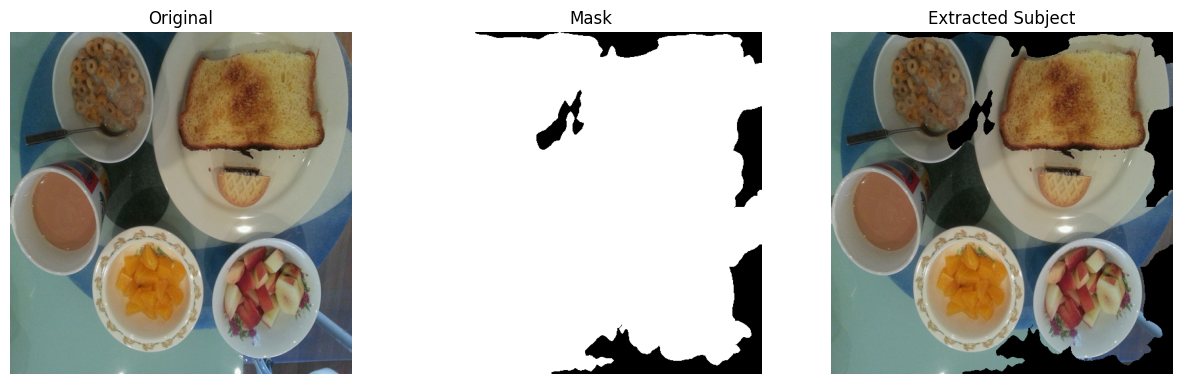

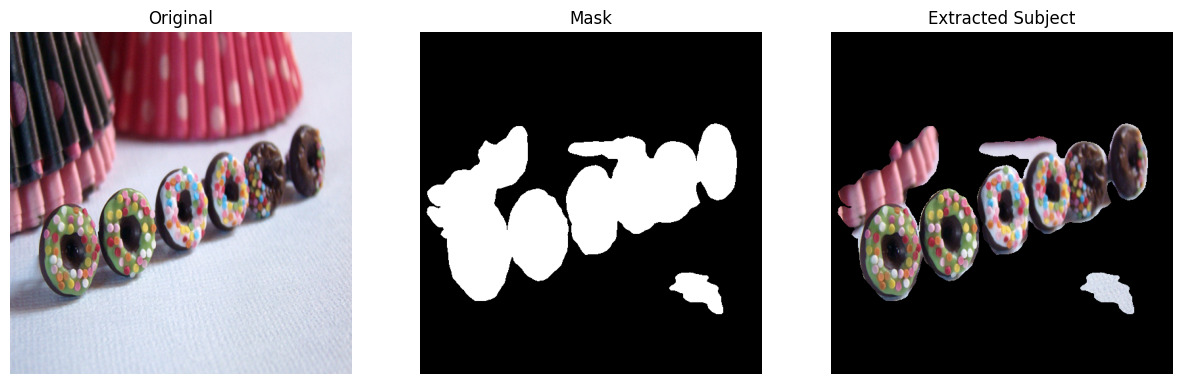

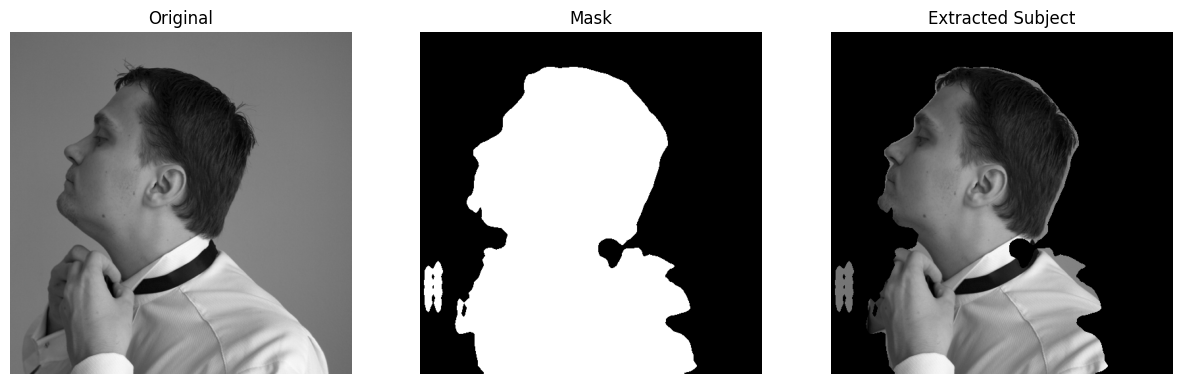

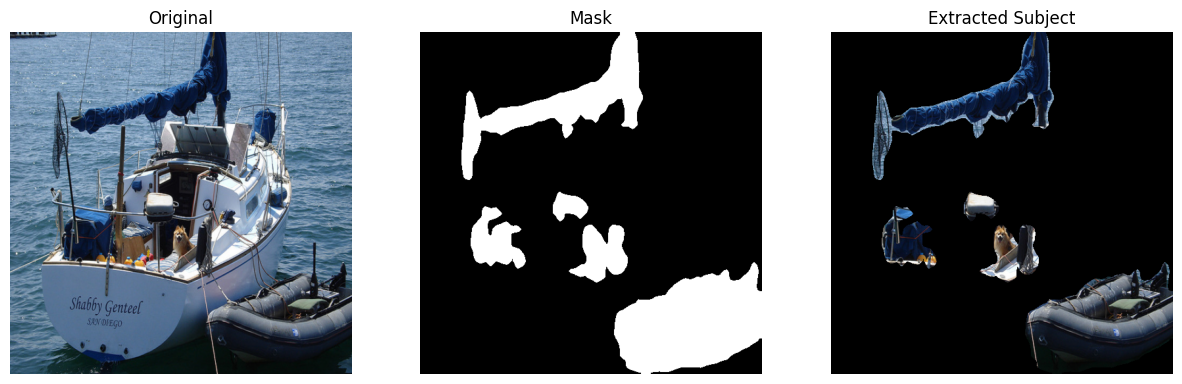

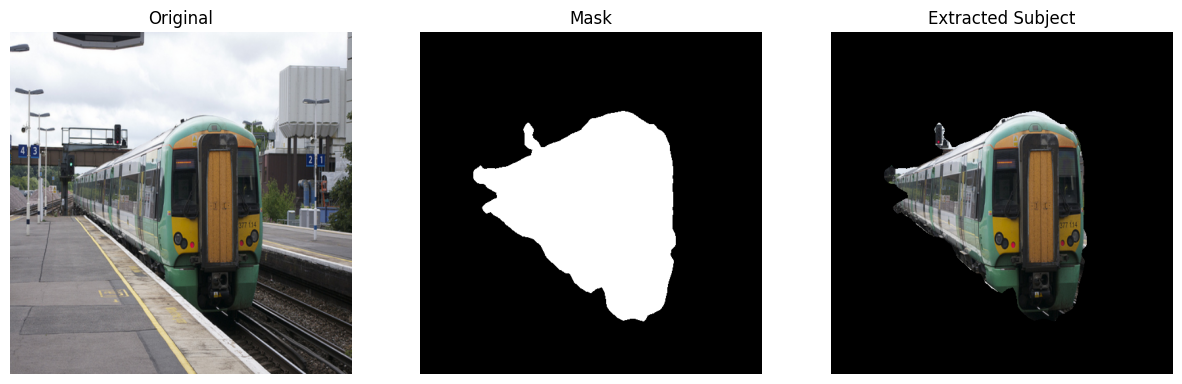

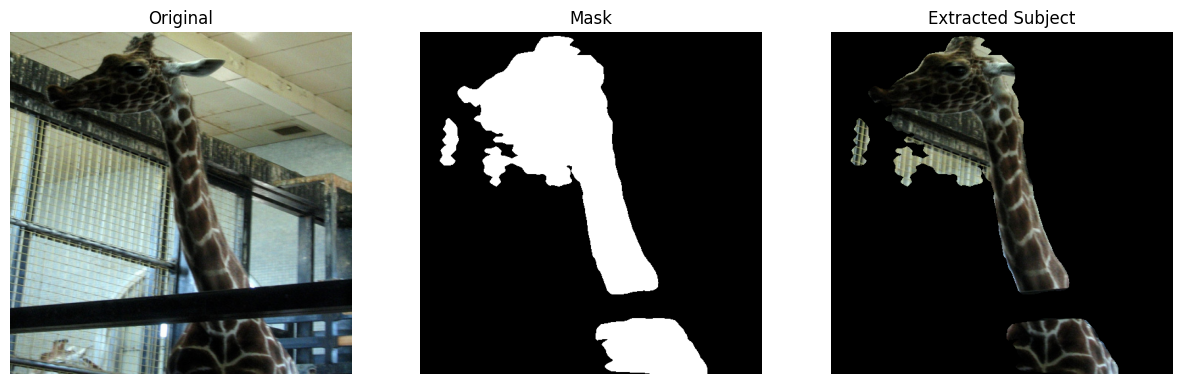

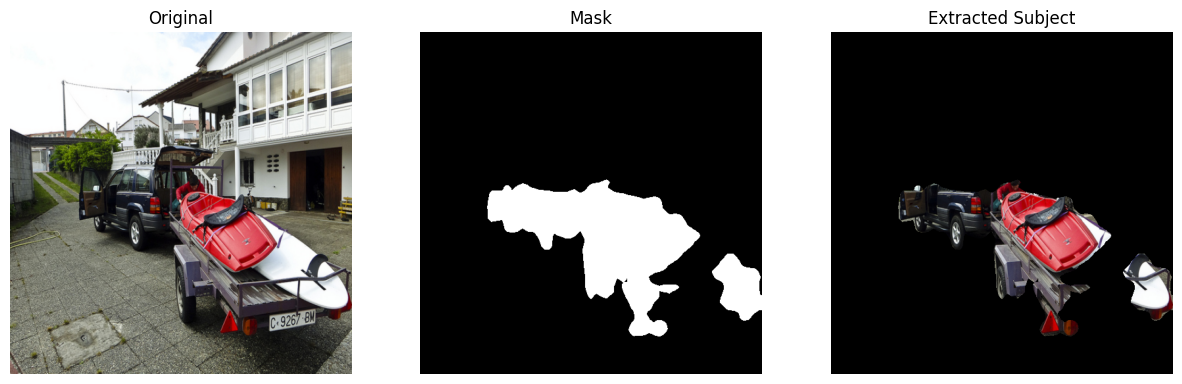

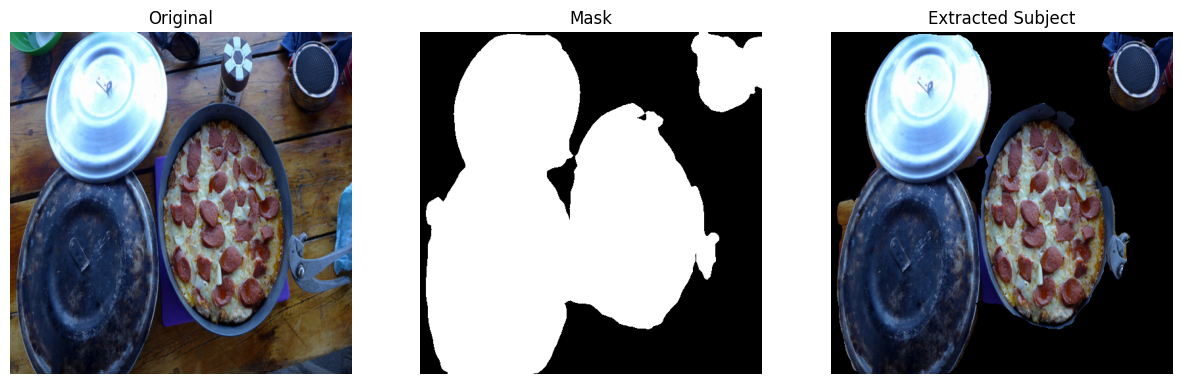

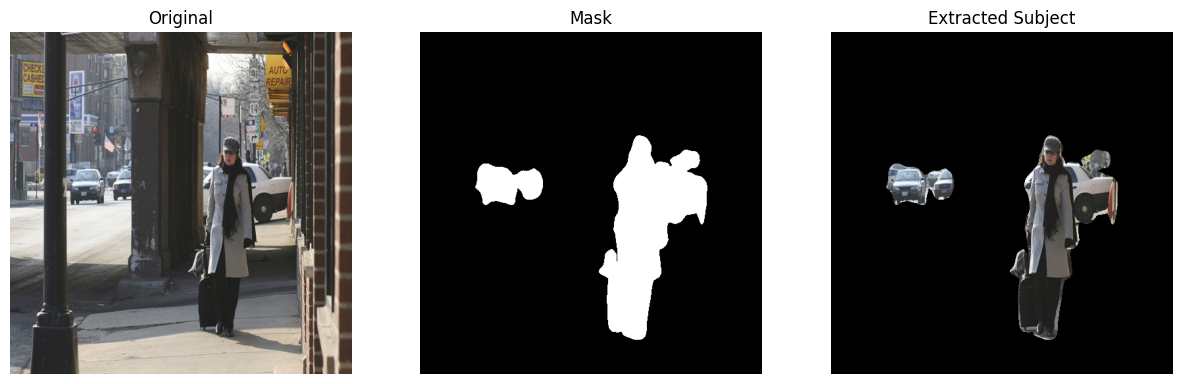

In [25]:
import os
import random
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from skimage import morphology
from skimage.morphology import disk
from scipy.ndimage import binary_dilation, gaussian_filter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\deeplabv3_resumed_epoch30.pth"
new_images_dir = r"C:\Users\ilaki\Desktop\VISON_AI\coco2017\testing images in internet"
output_dir = r"C:\Users\ilaki\Desktop\VISON_AI\new_model_extracted"
os.makedirs(output_dir, exist_ok=True)

num_classes = 2
model = deeplabv3_resnet50(num_classes=num_classes, aux_loss=False)
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def denormalize(tensor):
    img = tensor.clone().cpu().numpy().transpose(1,2,0)
    img = img * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    return np.clip(img,0,1)

def postprocess_mask(prob_mask, threshold=0.45, min_size=800, sigma=1.0, dilate_size=2):
    prob_mask = gaussian_filter(prob_mask, sigma=sigma)
    mask = (prob_mask > threshold).astype(np.uint8)
    mask = morphology.remove_small_objects(mask.astype(bool), min_size=min_size)
    mask = morphology.remove_small_holes(mask, area_threshold=min_size)
    mask = binary_dilation(mask, structure=disk(dilate_size))
    return mask.astype(np.uint8)

def extract_subject(img_np, mask):
    masked = img_np.copy()
    masked[mask==0] = 0
    return masked

all_images = [f for f in os.listdir(new_images_dir) if f.lower().endswith((".png",".jpg",".jpeg"))]
sample_images = random.sample(all_images, min(15, len(all_images)))

for img_name in sample_images:
    img_path = os.path.join(new_images_dir, img_name)
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(img_tensor)['out']
        prob_mask = torch.softmax(output, dim=1)[0,1].cpu().numpy()

    pred_bin = postprocess_mask(prob_mask)
    img_np = denormalize(img_tensor.squeeze())
    extracted = extract_subject(img_np, pred_bin)

    save_img = (extracted * 255).astype(np.uint8)
    Image.fromarray(save_img).save(os.path.join(output_dir, img_name))

    fig, axs = plt.subplots(1,3,figsize=(15,5))
    axs[0].imshow(img_np)
    axs[0].set_title("Original"); axs[0].axis("off")
    axs[1].imshow(pred_bin, cmap="gray")
    axs[1].set_title("Mask"); axs[1].axis("off")
    axs[2].imshow(extracted)
    axs[2].set_title("Extracted Subject"); axs[2].axis("off")
    plt.show()


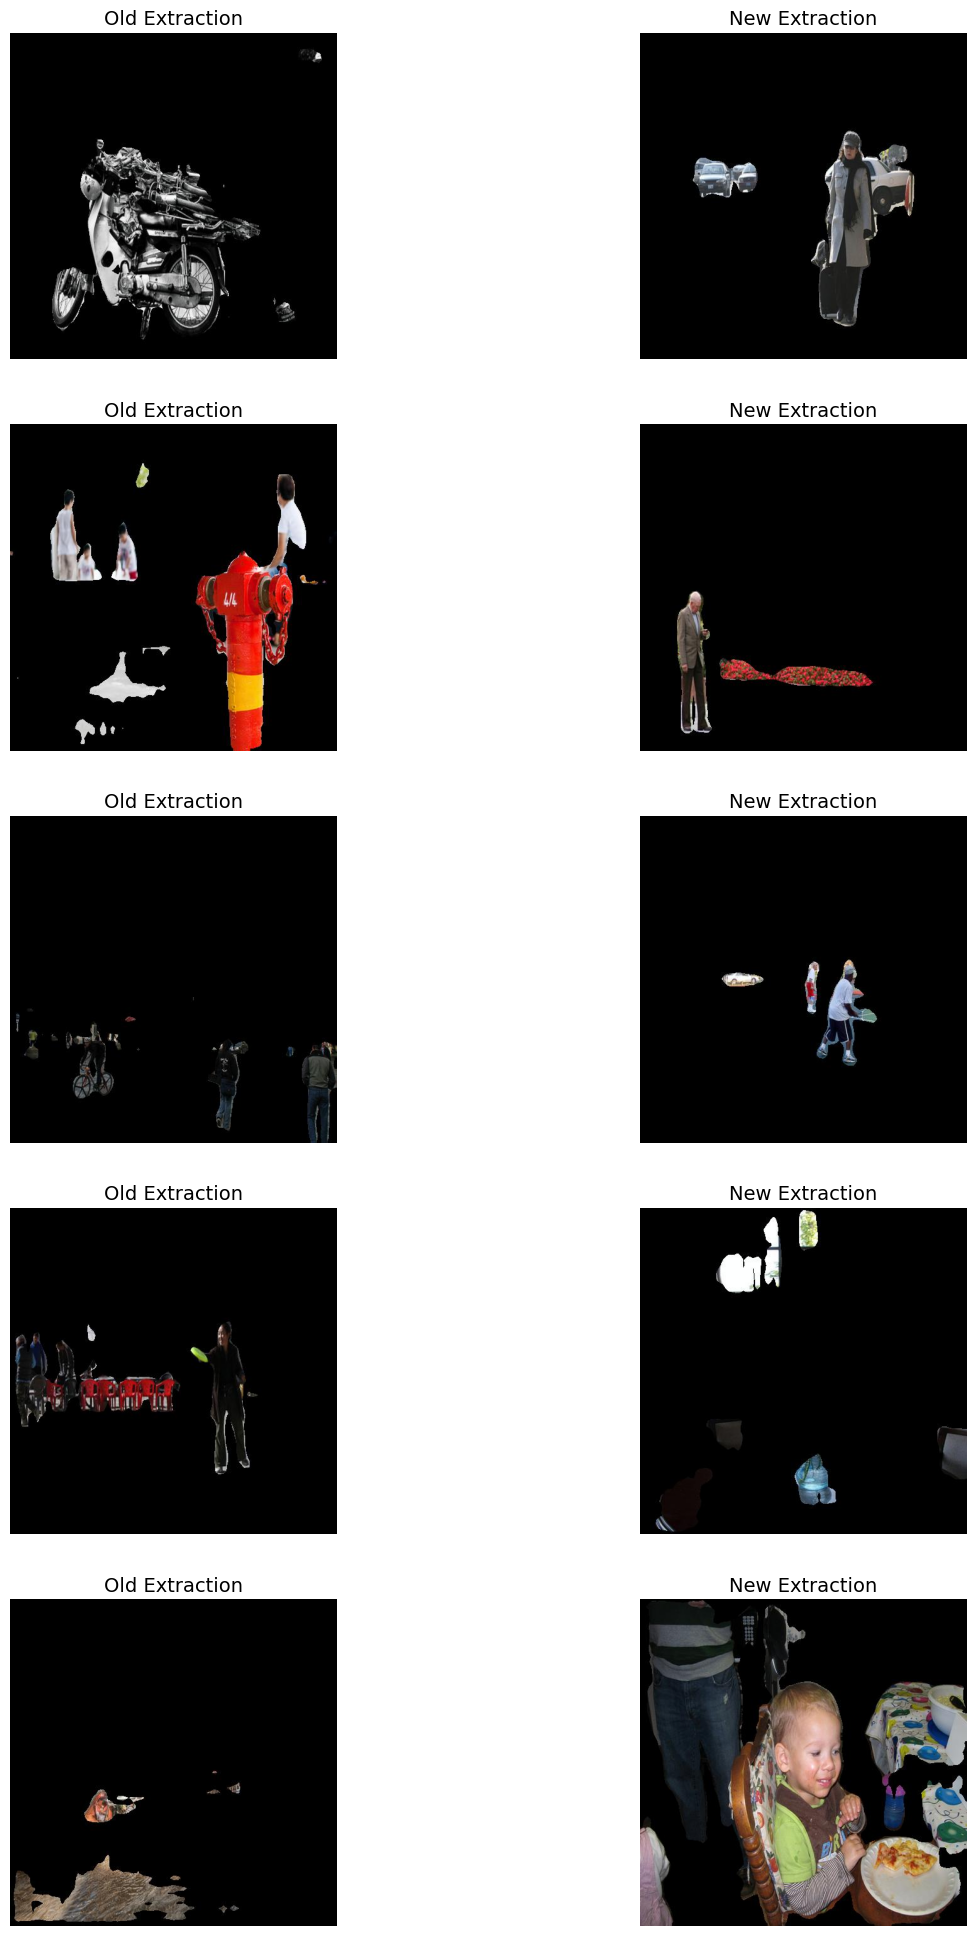

In [30]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

old_dir = r"C:\Users\ilaki\Desktop\VISON_AI\old_outputs"
new_dir = r"C:\Users\ilaki\Desktop\VISON_AI\new_model_extracted"

old_images = random.sample([f for f in os.listdir(old_dir) if f.lower().endswith((".png",".jpg"))], 5)
new_images = random.sample([f for f in os.listdir(new_dir) if f.lower().endswith((".png",".jpg"))], 5)

plt.figure(figsize=(16,20))  

for i, img_name in enumerate(old_images):
    plt.subplot(5,2,i*2+1)
    plt.imshow(Image.open(os.path.join(old_dir, img_name)))
    plt.title("Old Extraction", fontsize=14)
    plt.axis("off")

for i, img_name in enumerate(new_images):
    plt.subplot(5,2,i*2+2)
    plt.imshow(Image.open(os.path.join(new_dir, img_name)))
    plt.title("New Extraction", fontsize=14)
    plt.axis("off")

plt.tight_layout(pad=3.0)
plt.show()
